In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from MLib.PGM.Infections import preprocess_timeseries, beta_gamma_solver,\
    learn_beta_gamma_models, extract_data, create_SIR_data, \
    get_daily_policies, create_policy_dict, RegLinearRegression
from MLib.Learners.KerasLearner import MarkovChainRNN
from MLib.PGM.PGM import Factor, Factor_Given_Continuous, \
    compute_probability_policy_change, compute_uncertainty_given_policies,\
    check_policy_change_v3
from tensorflow.keras.preprocessing.sequence import pad_sequences
import copy
from MLib.Core.metrics import MAPE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from scipy.stats import norm

In [2]:
def Simulate_SIR(Population=3.5E6, beta=0.15, gamma=0.067, initial_I=100, initial_R=0,
    num_timesteps=300):

    # Simulate some data using the SIR model...
    initial_S = Population - initial_I - initial_R

    S = list()
    I = list()
    R = list()

    S.append(initial_S)
    I.append(initial_I)
    R.append(initial_R)

    for i in range(num_timesteps):

        normal_I = norm(0, .03*I[i])
        eta = np.round(normal_I.rvs())
        change_I = np.round(I[i]*S[i]/Population*beta)
        if change_I < 0:
            change_I = 0
        elif change_I > S[i]:
            change_I = S[i]

        normal_R = norm(0, .01*R[i])
        sigma = np.round(normal_R.rvs())
        change_R = np.round(gamma*I[i])
        if change_R < 0:
            change_R = 0
        elif change_R > I[i]:
            change_R = I[i]

        next_I = np.round(change_I - change_R + I[i])
        next_R = np.round(change_R + R[i])
        next_S = Population - next_I - next_R

        if next_S < 0:
            next_S = 0

        if next_I < 0:
            next_I = 0

        if next_I > Population:
            next_I = Population

        if next_R < 0:
            next_R = 0

        if next_R > Population:
            next_R = Population

        if next_S > S[i]:
            break
        S.append(next_S)
        I.append(next_I)
        R.append(next_R)

    # Create the training dataset
    X_train = []
    num_observations = len(S)

    for i in range(num_observations):
        X_train.append([S[i], I[i], R[i]])

    X_train = np.array(X_train)

    return X_train

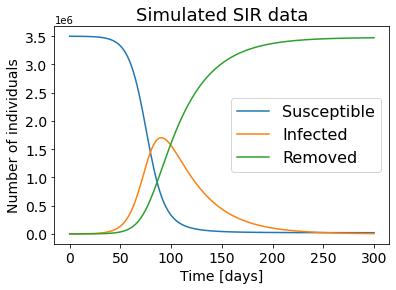

In [3]:
X_train = Simulate_SIR(beta = 0.15,gamma=.03, initial_I=500)

plt.figure()
plt.plot(X_train[:,0])
plt.plot(X_train[:,1])
plt.plot(X_train[:,2])

plt.legend(['Susceptible', 'Infected', 'Removed'], fontsize=16)

plt.xlabel('Time [days]',fontsize=14)
plt.xticks(fontsize=14)

plt.ylabel('Number of individuals',fontsize=14)
plt.yticks(fontsize=14)

plt.title('Simulated SIR data', fontsize=18)

plt.savefig('Simulated_data.png', dpi=400, bbox_inches='tight', transparent=False, facecolor='white')

In [4]:
# Fitting a fixed SIR model to the data
# -------------------------------------------------------------

# Create a dictionary with the population of the provinces
population_dict = dict()
population_dict['United States'] = 328E6

all_regions = population_dict.keys()

# Set the path to the directory with the Oxford Policy Tracker
policy_path = './covid-policy-tracker/data/OxCGRT_latest.csv'

# Load the dataset
data = pd.read_csv(policy_path)

# Estimate the betas per every day, in every province.
Params_dict = dict()

# Create a list to store a dateset with the policies and beta
country = 'United States'
all_regions = ['United States']

   
# Define the range of days to analyze, and the policies that we want
# to evaluate.
start_date = 20200327
end_date = 20210503
    
    
# Get the data from the current region only.
country_flag = data['CountryName'] == country
region_flag = data['Jurisdiction'] == 'NAT_TOTAL'
all_flags = np.logical_and(country_flag, region_flag)
country_data = data.loc[all_flags, :]

dates, processed_cases, processed_deaths, country_data_features = \
    extract_data(start_date, end_date, country_data, [])


# -----------------------------------------------------------
# Since the number of recovered is not in the data, assume that all the people
# who didn't die within 15 days has recovered.
population = population_dict[country]

S, I, R = create_SIR_data(population, processed_cases, 
                          processed_deaths, recovery_time=14)
    
beta, gamma = beta_gamma_solver(S[:-1], I[:-1], R[:-1])

/home/rvega/Envs/neurips/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_met

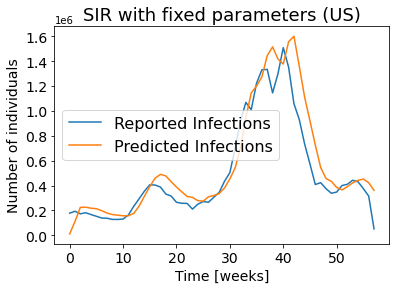

In [5]:
results_dict = dict()
results_dict['Start_date'] = list()
results_dict['End_date'] = list()
results_dict['Beta'] = list()
results_dict['Gamma'] = list()
results_dict['Predicted_Cases'] = list()
results_dict['Real_Cases'] = list()
results_dict['Predicted_Deaths'] = list()
results_dict['Real_Deaths'] = list()

beta, gamma = beta_gamma_solver(S[:-1], I[:-1], R[:-1])

for i in range(1, len(processed_cases), 7):
    start_indx = i
    last_indx = start_indx + 7

    S_train = S[start_indx:last_indx]
    I_train = I[start_indx:last_indx]
    R_train = R[start_indx:last_indx]

    # Create the MarkovChain and initialize it with a fake prediction
    rnn = MarkovChainRNN(population)
    X = np.array([[[0, 0, 0 ]]], dtype=np.float32)
    init_test = [ [S[start_indx-1], I[start_indx-1], R[start_indx-1]] ]

    rnn.predict(X, init_test)

    # Set the weights of the network
    rnn.model.set_weights([np.array([beta], dtype=np.float32),
                          np.array([gamma], dtype=np.float32)])

    X_test = [np.ones((7, 3))]
    X_test = pad_sequences(X_test, maxlen=None, dtype='float32', padding='pre', value=0.0)

    prediction, pred_state = rnn.predict(X_test, init_test)
    predicted_new_cases = S[start_indx-1] - prediction.numpy()[0][0]


    results_dict['Predicted_Cases'].append(predicted_new_cases)
    results_dict['Real_Cases'].append( S_train[0] - S_train[-1] )

plt.figure()
plt.plot(results_dict['Real_Cases'])
plt.plot(results_dict['Predicted_Cases'])

plt.xlabel('Time [weeks]',fontsize=14)
plt.xticks(fontsize=14)

plt.ylabel('Number of individuals',fontsize=14)
plt.yticks(fontsize=14)

plt.title('SIR with fixed parameters (US)', fontsize=18)

plt.legend(['Reported Infections', 'Predicted Infections'],fontsize=16)


plt.savefig('fixed_parameters.png', dpi=400, bbox_inches='tight', transparent=False, facecolor='white')


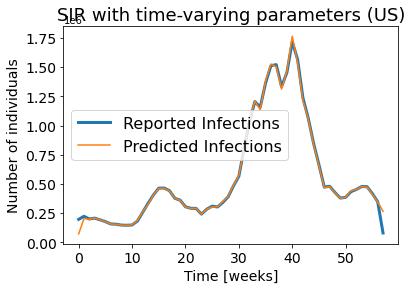

In [6]:
results_dict = dict()
results_dict['Start_date'] = list()
results_dict['End_date'] = list()
results_dict['Beta'] = list()
results_dict['Gamma'] = list()
results_dict['Predicted_Cases'] = list()
results_dict['Real_Cases'] = list()
results_dict['Predicted_Deaths'] = list()
results_dict['Real_Deaths'] = list()

for i in range(1, len(processed_cases), 7):
    start_indx = i
    last_indx = start_indx + 7

    S_train = S[start_indx-1:last_indx]
    I_train = I[start_indx-1:last_indx]
    R_train = R[start_indx-1:last_indx]

    beta, gamma = beta_gamma_solver(S_train, I_train, R_train)
    # Create the MarkovChain and initialize it with a fake prediction
    rnn = MarkovChainRNN(population)
    X = np.array([[[0, 0, 0 ]]], dtype=np.float32)
    init_test = [ [S[start_indx-1], I[start_indx-1], R[start_indx-1]] ]

    rnn.predict(X, init_test)

    # Set the weights of the network
    rnn.model.set_weights([np.array([beta], dtype=np.float32),
                          np.array([gamma], dtype=np.float32)])

    X_test = [np.ones((7, 3))]
    X_test = pad_sequences(X_test, maxlen=None, dtype='float32', padding='pre', value=0.0)

    prediction, pred_state = rnn.predict(X_test, init_test)
    predicted_new_cases = S[start_indx-1] - prediction.numpy()[0][0]


    results_dict['Predicted_Cases'].append(predicted_new_cases)
    results_dict['Real_Cases'].append( S_train[0] - S_train[-1] )

plt.figure()
plt.plot(results_dict['Real_Cases'], linewidth=3)
plt.plot(results_dict['Predicted_Cases'])

plt.xlabel('Time [weeks]',fontsize=14)
plt.xticks(fontsize=14)

plt.ylabel('Number of individuals',fontsize=14)
plt.yticks(fontsize=14)

plt.title('SIR with time-varying parameters (US)', fontsize=18)

plt.legend(['Reported Infections', 'Predicted Infections'],fontsize=16)

plt.savefig('time_varying_parameters.png', dpi=400, bbox_inches='tight', transparent=False, facecolor='white')